In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [4]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [5]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [6]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [7]:
X_cand = datos.drop(rg)
X_cand.shape

(4185, 9)

In [8]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4185, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [9]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [10]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [12]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


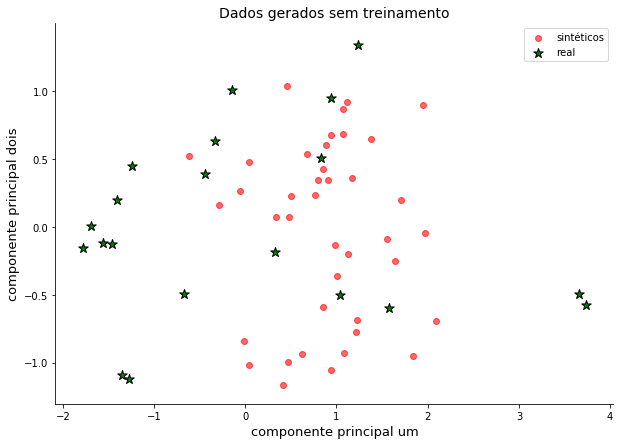

In [13]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [14]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(Dropout(.1))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [15]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [17]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [18]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision

In [40]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/1500)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/1500)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_5 (Sequential)    (None, 9)                 11559     
_________________________________________________________________
sequential_6 (Sequential)    (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [41]:
ep = 1500
g_loss, d_loss, precision = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/1500] [Discriminator::d_loss: 0.696862],[Generator::loss: 0.657163], 1.010337[sec]
epoch:[2/1500] [Discriminator::d_loss: 0.681739],[Generator::loss: 0.744255], 0.010435[sec]
epoch:[3/1500] [Discriminator::d_loss: 0.681877],[Generator::loss: 0.746725], 0.010406[sec]
epoch:[4/1500] [Discriminator::d_loss: 0.643129],[Generator::loss: 0.737694], 0.010318[sec]
epoch:[5/1500] [Discriminator::d_loss: 0.608837],[Generator::loss: 0.737434], 0.010340[sec]
epoch:[6/1500] [Discriminator::d_loss: 0.614164],[Generator::loss: 0.741051], 0.010340[sec]
epoch:[7/1500] [Discriminator::d_loss: 0.645809],[Generator::loss: 0.707566], 0.010561[sec]
epoch:[8/1500] [Discriminator::d_loss: 0.652858],[Generator::loss: 0.660666], 0.012218[sec]
epoch:[9/1500] [Discriminator::d_loss: 0.677556],[Generator::loss: 0.818074], 0.011891[sec]
epoch:[10/1500] [Discriminator::d_loss: 0.699466],[Generator::loss: 0.669113], 0.010315[sec]
epoch:[11/1500] [Discriminator::d_loss: 0.649826],[Generator::loss: 0.742723], 

epoch:[92/1500] [Discriminator::d_loss: 0.645043],[Generator::loss: 0.746475], 0.010339[sec]
epoch:[93/1500] [Discriminator::d_loss: 0.627904],[Generator::loss: 0.623589], 0.013013[sec]
epoch:[94/1500] [Discriminator::d_loss: 0.603724],[Generator::loss: 0.821575], 0.011180[sec]
epoch:[95/1500] [Discriminator::d_loss: 0.630623],[Generator::loss: 0.699696], 0.013503[sec]
epoch:[96/1500] [Discriminator::d_loss: 0.593556],[Generator::loss: 0.731693], 0.011411[sec]
epoch:[97/1500] [Discriminator::d_loss: 0.649178],[Generator::loss: 0.745404], 0.010512[sec]
epoch:[98/1500] [Discriminator::d_loss: 0.627870],[Generator::loss: 0.712407], 0.010803[sec]
epoch:[99/1500] [Discriminator::d_loss: 0.644372],[Generator::loss: 0.695306], 0.010482[sec]
epoch:[100/1500] [Discriminator::d_loss: 0.666941],[Generator::loss: 0.647613], 0.010473[sec]
epoch:[101/1500] [Discriminator::d_loss: 0.642122],[Generator::loss: 0.664922], 0.010466[sec]
epoch:[102/1500] [Discriminator::d_loss: 0.621054],[Generator::loss:

epoch:[185/1500] [Discriminator::d_loss: 0.596778],[Generator::loss: 0.757695], 0.011166[sec]
epoch:[186/1500] [Discriminator::d_loss: 0.586395],[Generator::loss: 0.726262], 0.013343[sec]
epoch:[187/1500] [Discriminator::d_loss: 0.635025],[Generator::loss: 0.678615], 0.012806[sec]
epoch:[188/1500] [Discriminator::d_loss: 0.621899],[Generator::loss: 0.818473], 0.010828[sec]
epoch:[189/1500] [Discriminator::d_loss: 0.597972],[Generator::loss: 0.752704], 0.010376[sec]
epoch:[190/1500] [Discriminator::d_loss: 0.597028],[Generator::loss: 0.753572], 0.010675[sec]
epoch:[191/1500] [Discriminator::d_loss: 0.623084],[Generator::loss: 0.782662], 0.010285[sec]
epoch:[192/1500] [Discriminator::d_loss: 0.590183],[Generator::loss: 0.756987], 0.010443[sec]
epoch:[193/1500] [Discriminator::d_loss: 0.601458],[Generator::loss: 0.715067], 0.010781[sec]
epoch:[194/1500] [Discriminator::d_loss: 0.617201],[Generator::loss: 0.751606], 0.010520[sec]
epoch:[195/1500] [Discriminator::d_loss: 0.622785],[Generato

epoch:[280/1500] [Discriminator::d_loss: 0.588467],[Generator::loss: 0.823000], 0.010676[sec]
epoch:[281/1500] [Discriminator::d_loss: 0.567898],[Generator::loss: 0.814387], 0.011991[sec]
epoch:[282/1500] [Discriminator::d_loss: 0.565244],[Generator::loss: 0.797980], 0.010997[sec]
epoch:[283/1500] [Discriminator::d_loss: 0.567550],[Generator::loss: 0.789942], 0.010275[sec]
epoch:[284/1500] [Discriminator::d_loss: 0.562963],[Generator::loss: 0.844113], 0.010434[sec]
epoch:[285/1500] [Discriminator::d_loss: 0.610185],[Generator::loss: 0.849515], 0.010213[sec]
epoch:[286/1500] [Discriminator::d_loss: 0.571637],[Generator::loss: 0.793293], 0.010378[sec]
epoch:[287/1500] [Discriminator::d_loss: 0.577784],[Generator::loss: 0.784500], 0.010191[sec]
epoch:[288/1500] [Discriminator::d_loss: 0.565445],[Generator::loss: 0.823221], 0.010304[sec]
epoch:[289/1500] [Discriminator::d_loss: 0.591592],[Generator::loss: 0.760197], 0.010169[sec]
epoch:[290/1500] [Discriminator::d_loss: 0.597141],[Generato

epoch:[375/1500] [Discriminator::d_loss: 0.549984],[Generator::loss: 0.879056], 0.011027[sec]
epoch:[376/1500] [Discriminator::d_loss: 0.542815],[Generator::loss: 0.854533], 0.018325[sec]
epoch:[377/1500] [Discriminator::d_loss: 0.573734],[Generator::loss: 0.844549], 0.012796[sec]
epoch:[378/1500] [Discriminator::d_loss: 0.596922],[Generator::loss: 0.867627], 0.010413[sec]
epoch:[379/1500] [Discriminator::d_loss: 0.577821],[Generator::loss: 0.838989], 0.010112[sec]
epoch:[380/1500] [Discriminator::d_loss: 0.559859],[Generator::loss: 0.839716], 0.010443[sec]
epoch:[381/1500] [Discriminator::d_loss: 0.595851],[Generator::loss: 0.803151], 0.010326[sec]
epoch:[382/1500] [Discriminator::d_loss: 0.565827],[Generator::loss: 0.836830], 0.010262[sec]
epoch:[383/1500] [Discriminator::d_loss: 0.553640],[Generator::loss: 0.799580], 0.010448[sec]
epoch:[384/1500] [Discriminator::d_loss: 0.548973],[Generator::loss: 0.805908], 0.010373[sec]
epoch:[385/1500] [Discriminator::d_loss: 0.565604],[Generato

epoch:[469/1500] [Discriminator::d_loss: 0.587263],[Generator::loss: 0.970734], 0.011593[sec]
epoch:[470/1500] [Discriminator::d_loss: 0.528933],[Generator::loss: 0.874015], 0.011595[sec]
epoch:[471/1500] [Discriminator::d_loss: 0.545412],[Generator::loss: 0.925518], 0.011345[sec]
epoch:[472/1500] [Discriminator::d_loss: 0.523575],[Generator::loss: 0.925267], 0.010492[sec]
epoch:[473/1500] [Discriminator::d_loss: 0.532951],[Generator::loss: 0.869336], 0.010554[sec]
epoch:[474/1500] [Discriminator::d_loss: 0.569516],[Generator::loss: 0.809546], 0.010545[sec]
epoch:[475/1500] [Discriminator::d_loss: 0.570858],[Generator::loss: 0.916523], 0.010440[sec]
epoch:[476/1500] [Discriminator::d_loss: 0.563369],[Generator::loss: 0.854970], 0.010256[sec]
epoch:[477/1500] [Discriminator::d_loss: 0.594605],[Generator::loss: 0.941126], 0.010226[sec]
epoch:[478/1500] [Discriminator::d_loss: 0.541634],[Generator::loss: 0.887900], 0.010278[sec]
epoch:[479/1500] [Discriminator::d_loss: 0.509746],[Generato

epoch:[564/1500] [Discriminator::d_loss: 0.581322],[Generator::loss: 0.924335], 0.011333[sec]
epoch:[565/1500] [Discriminator::d_loss: 0.561140],[Generator::loss: 0.913745], 0.012668[sec]
epoch:[566/1500] [Discriminator::d_loss: 0.520869],[Generator::loss: 0.883104], 0.010968[sec]
epoch:[567/1500] [Discriminator::d_loss: 0.538802],[Generator::loss: 0.881545], 0.010216[sec]
epoch:[568/1500] [Discriminator::d_loss: 0.537398],[Generator::loss: 0.923289], 0.010503[sec]
epoch:[569/1500] [Discriminator::d_loss: 0.557439],[Generator::loss: 0.873971], 0.010139[sec]
epoch:[570/1500] [Discriminator::d_loss: 0.535400],[Generator::loss: 0.898934], 0.010295[sec]
epoch:[571/1500] [Discriminator::d_loss: 0.518784],[Generator::loss: 0.864868], 0.010087[sec]
epoch:[572/1500] [Discriminator::d_loss: 0.548179],[Generator::loss: 0.918857], 0.010075[sec]
epoch:[573/1500] [Discriminator::d_loss: 0.546894],[Generator::loss: 0.815462], 0.009975[sec]
epoch:[574/1500] [Discriminator::d_loss: 0.529127],[Generato

epoch:[659/1500] [Discriminator::d_loss: 0.559419],[Generator::loss: 0.879339], 0.011532[sec]
epoch:[660/1500] [Discriminator::d_loss: 0.549782],[Generator::loss: 0.820171], 0.013031[sec]
epoch:[661/1500] [Discriminator::d_loss: 0.577741],[Generator::loss: 0.923691], 0.010747[sec]
epoch:[662/1500] [Discriminator::d_loss: 0.592460],[Generator::loss: 0.858746], 0.010579[sec]
epoch:[663/1500] [Discriminator::d_loss: 0.558837],[Generator::loss: 0.846444], 0.010407[sec]
epoch:[664/1500] [Discriminator::d_loss: 0.535597],[Generator::loss: 0.974115], 0.010201[sec]
epoch:[665/1500] [Discriminator::d_loss: 0.523711],[Generator::loss: 0.934917], 0.010231[sec]
epoch:[666/1500] [Discriminator::d_loss: 0.590586],[Generator::loss: 0.909144], 0.010262[sec]
epoch:[667/1500] [Discriminator::d_loss: 0.535524],[Generator::loss: 0.778561], 0.010258[sec]
epoch:[668/1500] [Discriminator::d_loss: 0.523514],[Generator::loss: 0.871090], 0.010231[sec]
epoch:[669/1500] [Discriminator::d_loss: 0.518945],[Generato

epoch:[754/1500] [Discriminator::d_loss: 0.566815],[Generator::loss: 0.847478], 0.011692[sec]
epoch:[755/1500] [Discriminator::d_loss: 0.548096],[Generator::loss: 0.982756], 0.011356[sec]
epoch:[756/1500] [Discriminator::d_loss: 0.579450],[Generator::loss: 0.865401], 0.011551[sec]
epoch:[757/1500] [Discriminator::d_loss: 0.554949],[Generator::loss: 0.865255], 0.010502[sec]
epoch:[758/1500] [Discriminator::d_loss: 0.602058],[Generator::loss: 0.873559], 0.010388[sec]
epoch:[759/1500] [Discriminator::d_loss: 0.566510],[Generator::loss: 0.967669], 0.010330[sec]
epoch:[760/1500] [Discriminator::d_loss: 0.549960],[Generator::loss: 0.869692], 0.010344[sec]
epoch:[761/1500] [Discriminator::d_loss: 0.592210],[Generator::loss: 0.858581], 0.010173[sec]
epoch:[762/1500] [Discriminator::d_loss: 0.568793],[Generator::loss: 0.917881], 0.010290[sec]
epoch:[763/1500] [Discriminator::d_loss: 0.559407],[Generator::loss: 0.922282], 0.010458[sec]
epoch:[764/1500] [Discriminator::d_loss: 0.631390],[Generato

epoch:[848/1500] [Discriminator::d_loss: 0.648802],[Generator::loss: 0.881985], 0.012842[sec]
epoch:[849/1500] [Discriminator::d_loss: 0.598996],[Generator::loss: 0.787992], 0.013784[sec]
epoch:[850/1500] [Discriminator::d_loss: 0.603220],[Generator::loss: 0.871730], 0.011442[sec]
epoch:[851/1500] [Discriminator::d_loss: 0.548014],[Generator::loss: 0.853323], 0.010474[sec]
epoch:[852/1500] [Discriminator::d_loss: 0.663435],[Generator::loss: 0.948350], 0.010524[sec]
epoch:[853/1500] [Discriminator::d_loss: 0.578373],[Generator::loss: 0.815218], 0.010330[sec]
epoch:[854/1500] [Discriminator::d_loss: 0.629714],[Generator::loss: 0.766609], 0.010194[sec]
epoch:[855/1500] [Discriminator::d_loss: 0.607734],[Generator::loss: 0.741401], 0.010163[sec]
epoch:[856/1500] [Discriminator::d_loss: 0.644764],[Generator::loss: 0.879909], 0.010268[sec]
epoch:[857/1500] [Discriminator::d_loss: 0.594953],[Generator::loss: 0.835571], 0.010254[sec]
epoch:[858/1500] [Discriminator::d_loss: 0.574708],[Generato

epoch:[943/1500] [Discriminator::d_loss: 0.621995],[Generator::loss: 0.793863], 0.012773[sec]
epoch:[944/1500] [Discriminator::d_loss: 0.753214],[Generator::loss: 0.852399], 0.012175[sec]
epoch:[945/1500] [Discriminator::d_loss: 0.676089],[Generator::loss: 0.889426], 0.012808[sec]
epoch:[946/1500] [Discriminator::d_loss: 0.722750],[Generator::loss: 0.840890], 0.010426[sec]
epoch:[947/1500] [Discriminator::d_loss: 0.666559],[Generator::loss: 0.902305], 0.010359[sec]
epoch:[948/1500] [Discriminator::d_loss: 0.668335],[Generator::loss: 0.927287], 0.010228[sec]
epoch:[949/1500] [Discriminator::d_loss: 0.676655],[Generator::loss: 0.742106], 0.010178[sec]
epoch:[950/1500] [Discriminator::d_loss: 0.670109],[Generator::loss: 0.840457], 0.010245[sec]
epoch:[951/1500] [Discriminator::d_loss: 0.686994],[Generator::loss: 0.873260], 0.010204[sec]
epoch:[952/1500] [Discriminator::d_loss: 0.645284],[Generator::loss: 0.777528], 0.010309[sec]
epoch:[953/1500] [Discriminator::d_loss: 0.642526],[Generato

epoch:[1038/1500] [Discriminator::d_loss: 0.691394],[Generator::loss: 0.835090], 0.011357[sec]
epoch:[1039/1500] [Discriminator::d_loss: 0.642678],[Generator::loss: 0.827535], 0.011622[sec]
epoch:[1040/1500] [Discriminator::d_loss: 0.712799],[Generator::loss: 0.651930], 0.013876[sec]
epoch:[1041/1500] [Discriminator::d_loss: 0.667287],[Generator::loss: 0.776669], 0.010434[sec]
epoch:[1042/1500] [Discriminator::d_loss: 0.694922],[Generator::loss: 0.831325], 0.010458[sec]
epoch:[1043/1500] [Discriminator::d_loss: 0.690608],[Generator::loss: 0.887686], 0.010469[sec]
epoch:[1044/1500] [Discriminator::d_loss: 0.674752],[Generator::loss: 0.797438], 0.010201[sec]
epoch:[1045/1500] [Discriminator::d_loss: 0.662924],[Generator::loss: 0.835763], 0.010423[sec]
epoch:[1046/1500] [Discriminator::d_loss: 0.627013],[Generator::loss: 0.868776], 0.010121[sec]
epoch:[1047/1500] [Discriminator::d_loss: 0.696610],[Generator::loss: 0.928415], 0.010233[sec]
epoch:[1048/1500] [Discriminator::d_loss: 0.656703

epoch:[1133/1500] [Discriminator::d_loss: 0.692190],[Generator::loss: 0.731789], 0.011961[sec]
epoch:[1134/1500] [Discriminator::d_loss: 0.732886],[Generator::loss: 0.746180], 0.011232[sec]
epoch:[1135/1500] [Discriminator::d_loss: 0.694912],[Generator::loss: 0.787145], 0.012177[sec]
epoch:[1136/1500] [Discriminator::d_loss: 0.679810],[Generator::loss: 0.920084], 0.010418[sec]
epoch:[1137/1500] [Discriminator::d_loss: 0.683220],[Generator::loss: 0.819010], 0.011180[sec]
epoch:[1138/1500] [Discriminator::d_loss: 0.656508],[Generator::loss: 0.709740], 0.010527[sec]
epoch:[1139/1500] [Discriminator::d_loss: 0.687819],[Generator::loss: 0.806388], 0.010240[sec]
epoch:[1140/1500] [Discriminator::d_loss: 0.670744],[Generator::loss: 0.739487], 0.010247[sec]
epoch:[1141/1500] [Discriminator::d_loss: 0.666368],[Generator::loss: 0.801323], 0.010338[sec]
epoch:[1142/1500] [Discriminator::d_loss: 0.707796],[Generator::loss: 0.762270], 0.010218[sec]
epoch:[1143/1500] [Discriminator::d_loss: 0.732690

epoch:[1228/1500] [Discriminator::d_loss: 0.658885],[Generator::loss: 0.802520], 0.012890[sec]
epoch:[1229/1500] [Discriminator::d_loss: 0.673543],[Generator::loss: 0.696889], 0.014141[sec]
epoch:[1230/1500] [Discriminator::d_loss: 0.694520],[Generator::loss: 0.828141], 0.011421[sec]
epoch:[1231/1500] [Discriminator::d_loss: 0.701100],[Generator::loss: 0.748699], 0.010792[sec]
epoch:[1232/1500] [Discriminator::d_loss: 0.701082],[Generator::loss: 0.864494], 0.010391[sec]
epoch:[1233/1500] [Discriminator::d_loss: 0.642291],[Generator::loss: 0.723582], 0.010406[sec]
epoch:[1234/1500] [Discriminator::d_loss: 0.742314],[Generator::loss: 0.757377], 0.010322[sec]
epoch:[1235/1500] [Discriminator::d_loss: 0.671869],[Generator::loss: 0.749871], 0.010420[sec]
epoch:[1236/1500] [Discriminator::d_loss: 0.695950],[Generator::loss: 0.863189], 0.010578[sec]
epoch:[1237/1500] [Discriminator::d_loss: 0.719628],[Generator::loss: 0.768017], 0.010339[sec]
epoch:[1238/1500] [Discriminator::d_loss: 0.719530

epoch:[1323/1500] [Discriminator::d_loss: 0.720350],[Generator::loss: 0.777708], 0.011678[sec]
epoch:[1324/1500] [Discriminator::d_loss: 0.709801],[Generator::loss: 0.793385], 0.013193[sec]
epoch:[1325/1500] [Discriminator::d_loss: 0.697550],[Generator::loss: 0.754514], 0.010733[sec]
epoch:[1326/1500] [Discriminator::d_loss: 0.657120],[Generator::loss: 0.708431], 0.010532[sec]
epoch:[1327/1500] [Discriminator::d_loss: 0.716963],[Generator::loss: 0.800590], 0.010403[sec]
epoch:[1328/1500] [Discriminator::d_loss: 0.727193],[Generator::loss: 0.750934], 0.010547[sec]
epoch:[1329/1500] [Discriminator::d_loss: 0.716711],[Generator::loss: 0.765058], 0.010420[sec]
epoch:[1330/1500] [Discriminator::d_loss: 0.725643],[Generator::loss: 0.727204], 0.010296[sec]
epoch:[1331/1500] [Discriminator::d_loss: 0.723907],[Generator::loss: 0.900918], 0.010346[sec]
epoch:[1332/1500] [Discriminator::d_loss: 0.724985],[Generator::loss: 0.704321], 0.010188[sec]
epoch:[1333/1500] [Discriminator::d_loss: 0.698998

epoch:[1418/1500] [Discriminator::d_loss: 0.720695],[Generator::loss: 0.777669], 0.011255[sec]
epoch:[1419/1500] [Discriminator::d_loss: 0.708802],[Generator::loss: 0.757865], 0.013144[sec]
epoch:[1420/1500] [Discriminator::d_loss: 0.685779],[Generator::loss: 0.798943], 0.012525[sec]
epoch:[1421/1500] [Discriminator::d_loss: 0.740881],[Generator::loss: 0.821060], 0.010436[sec]
epoch:[1422/1500] [Discriminator::d_loss: 0.710547],[Generator::loss: 0.798926], 0.010399[sec]
epoch:[1423/1500] [Discriminator::d_loss: 0.692196],[Generator::loss: 0.736452], 0.010292[sec]
epoch:[1424/1500] [Discriminator::d_loss: 0.715783],[Generator::loss: 0.776631], 0.010172[sec]
epoch:[1425/1500] [Discriminator::d_loss: 0.693837],[Generator::loss: 0.814256], 0.010326[sec]
epoch:[1426/1500] [Discriminator::d_loss: 0.684331],[Generator::loss: 0.777611], 0.010311[sec]
epoch:[1427/1500] [Discriminator::d_loss: 0.699056],[Generator::loss: 0.698628], 0.010280[sec]
epoch:[1428/1500] [Discriminator::d_loss: 0.726265

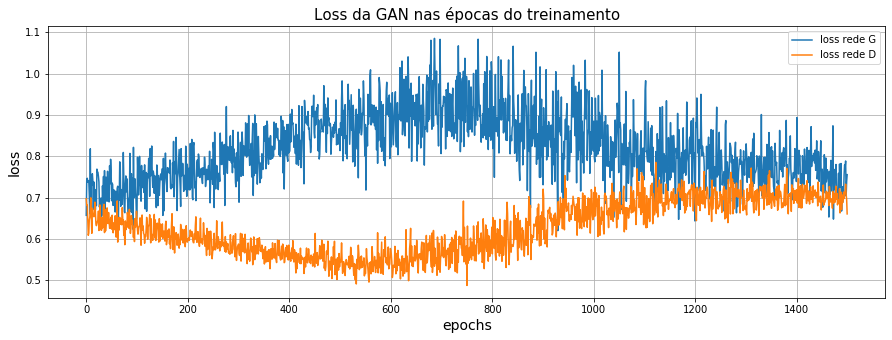

In [42]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

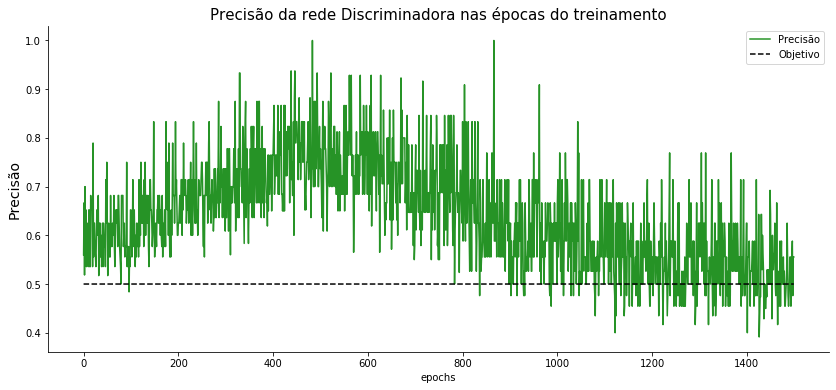

In [43]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

(20, 2) (300, 2)


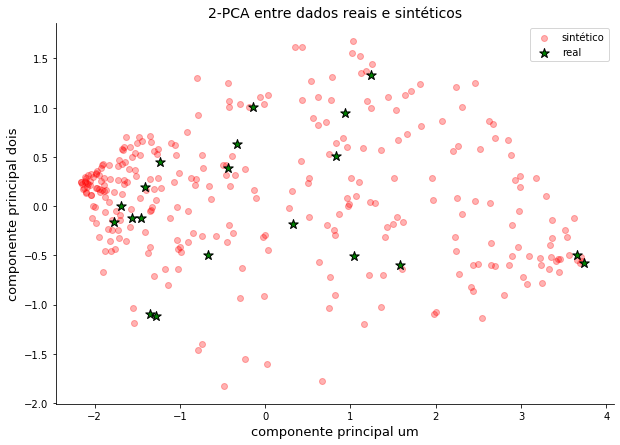

In [48]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [49]:
score = []
for i in range(10000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(precision_score(y_test, y_predict))

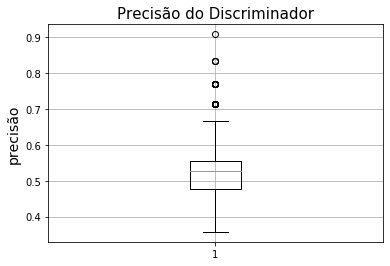

In [50]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [51]:
np.mean(score), np.std(score), np.median(score)

(0.5207038776213591, 0.06207234729601424, 0.5263157894736842)

In [52]:
X_train.shape

(20, 9)

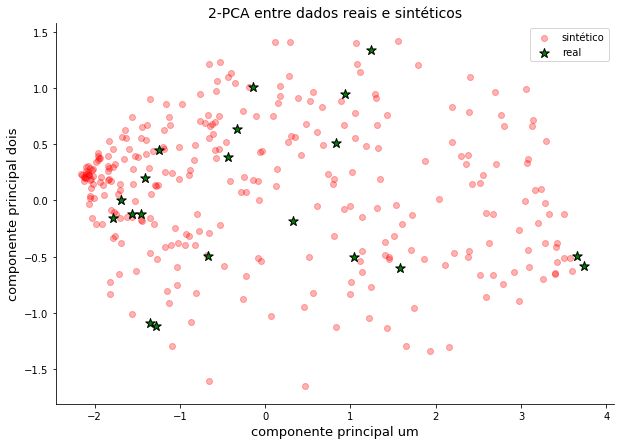

In [54]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [158]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.mean(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [161]:
dt_cv, best_idx = best_sample(G, 300, 400, noise_input)

In [162]:
best_idx

143

### One-class classification with SVM

In [57]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.0121, gamma=.19).fit(X_nov)

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9681528662420382
score nos genes de referência de treinamento:  0.9285714285714286
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.9


In [58]:
#gan.save("./data/best_gan.h5")

In [59]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [60]:
predict_cand = clf.predict(X_cand)

In [61]:
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

((800, 9), (3385, 9))

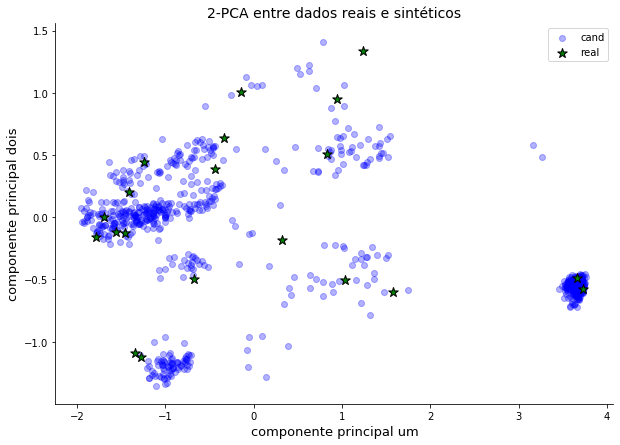

In [62]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [63]:
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

redução do  80.97502972651604 % no processo de escolha de candidatos


In [64]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [65]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [66]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [67]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


In [154]:
class one_class_gan:
    
    def __init__(self, X_train, noise_input, epochs):
        self.X_train = X_train
        self.noise_input = noise_input
        self.epochs = epochs
        #building gan
        optG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/self.epochs)
        optD = SGD(lr=0.00021, momentum=0.92, decay=0.0001/self.epochs)
        self.G = self.generator(optG)
        self.D = self.discriminator(optD)
        self.gan = self.build_gan(self.G, self.D, optG) 
        
    def generator(self, opt):
        model = Sequential()
        model.add(Dense(30, input_shape=(self.noise_input,)))
        model.add(Dense(30))
        model.add(Dense(X_train.shape[1], activation="tanh"))
        model.compile(loss="binary_crossentropy",
                      optimizer=opt)
        return model
    
    def discriminator(self, opt):
        model = Sequential()
        model.add(Dense(128, input_shape=(self.X_train.shape[1],)))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(64))
        model.add(Dense(32))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=opt)
        return model
    
    def build_gan(self, G, D, opt):
        model = Sequential()
        model.add(G)
        D.trainable = False
        model.add(D)
        model.compile(loss="binary_crossentropy", optimizer=opt)
        return model
        
    def get_batches(self, batch_size):
        """
        X_train: dataset para o treino
        epochs: quantidade de epocas para o treino do gradiente
        batch: tamanho to batch pra o treino de cada epochs
        """
        batches = []
        num_bat = int(np.ceil(self.X_train.shape[0]/batch_size))
        lim_i = 0
        lim_s = batch_size
        for i in range(num_bat):
            if lim_s > self.X_train.shape[0]:
                lim_s = self.X_train.shape[0]
            batches.append(self.X_train[lim_i:lim_s])
            lim_i += batch_size
            lim_s += batch_size
        return batches

    def train(self, epochs, batch_size):       
        g_loss = []
        d_loss = []
        precision = []
        for epoch in range(epochs):
            batches = self.get_batches(batch_size)
            count_b = 0
            t_i = time()
            d_bacth_loss = []
            g_bacth_loss = []
            for batch in batches:
                gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), self.noise_input))
                #gerando as imagens fake
                syntetic_data = self.G.predict(gen_noise)
                #criação do array de treinamento
                x_combined_batch = np.concatenate((batch, syntetic_data))
                y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                                   np.zeros((batch.shape[0], 1))))
                #misturar os dados
                #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
                #treino do discriminador
                d_bacth_loss.append(self.D.train_on_batch(x_combined_batch, y_combined_batch)[0])
                # train generator
                noise = np.random.normal(0, 1, (batch.shape[0], self.noise_input))
                y_mislabled = np.ones((batch.shape[0], 1))
                g_bacth_loss.append(self.gan.train_on_batch(noise, y_mislabled))

            #precision
            X_sint = self.G.predict(np.random.normal(0, 1, (self.X_train.shape[0], self.noise_input)))
            X_comb = np.concatenate((self.X_train, X_sint))
            y_comb = np.concatenate((np.ones((self.X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
            y_predict = self.D.predict_classes(X_comb)
            #f1_lag = f1_score(y_test, y_predict)
            precision.append(precision_score(y_comb, y_predict))
            #fscore.append(f1_lag)
            t_f = time()
            t = t_f - t_i
            t_i = time()
            #d_loss.append(np.mean(np.array(d_bacth_loss)))
            #g_loss.append(np.mean(np.array(g_bacth_loss)))
            d_loss.append(d_bacth_loss[-1])
            g_loss.append(g_bacth_loss[-1])
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                       % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
            #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
            #    break
        return g_loss, d_loss, precision

In [155]:
X_nov.shape

(314, 9)

In [156]:
obj_oc = one_class_gan(X_nov, 50, 1000)
gloss, dloss, d_precision  = obj_oc.train(1000, batch_size=int(X_nov.shape[0]))

epoch:[1/1000] [Discriminator::d_loss: 0.746245],[Generator::loss: 0.860223], 1.930268[sec]
epoch:[2/1000] [Discriminator::d_loss: 0.740365],[Generator::loss: 0.873091], 0.031229[sec]
epoch:[3/1000] [Discriminator::d_loss: 0.748399],[Generator::loss: 0.902758], 0.031521[sec]
epoch:[4/1000] [Discriminator::d_loss: 0.745964],[Generator::loss: 0.878662], 0.031005[sec]
epoch:[5/1000] [Discriminator::d_loss: 0.741356],[Generator::loss: 0.887164], 0.031445[sec]
epoch:[6/1000] [Discriminator::d_loss: 0.739816],[Generator::loss: 0.865471], 0.029828[sec]
epoch:[7/1000] [Discriminator::d_loss: 0.740039],[Generator::loss: 0.882209], 0.029025[sec]
epoch:[8/1000] [Discriminator::d_loss: 0.743635],[Generator::loss: 0.859898], 0.032923[sec]
epoch:[9/1000] [Discriminator::d_loss: 0.737955],[Generator::loss: 0.871129], 0.038237[sec]
epoch:[10/1000] [Discriminator::d_loss: 0.732992],[Generator::loss: 0.849895], 0.028504[sec]
epoch:[11/1000] [Discriminator::d_loss: 0.745697],[Generator::loss: 0.892264], 

epoch:[92/1000] [Discriminator::d_loss: 0.668491],[Generator::loss: 0.770164], 0.040072[sec]
epoch:[93/1000] [Discriminator::d_loss: 0.668159],[Generator::loss: 0.792502], 0.033797[sec]
epoch:[94/1000] [Discriminator::d_loss: 0.674871],[Generator::loss: 0.795097], 0.034383[sec]
epoch:[95/1000] [Discriminator::d_loss: 0.671822],[Generator::loss: 0.780956], 0.030917[sec]
epoch:[96/1000] [Discriminator::d_loss: 0.663923],[Generator::loss: 0.773816], 0.028524[sec]
epoch:[97/1000] [Discriminator::d_loss: 0.673712],[Generator::loss: 0.785451], 0.028644[sec]
epoch:[98/1000] [Discriminator::d_loss: 0.660476],[Generator::loss: 0.779084], 0.028720[sec]
epoch:[99/1000] [Discriminator::d_loss: 0.672668],[Generator::loss: 0.776520], 0.036183[sec]
epoch:[100/1000] [Discriminator::d_loss: 0.668647],[Generator::loss: 0.769589], 0.029272[sec]
epoch:[101/1000] [Discriminator::d_loss: 0.664568],[Generator::loss: 0.779865], 0.028601[sec]
epoch:[102/1000] [Discriminator::d_loss: 0.660517],[Generator::loss:

epoch:[183/1000] [Discriminator::d_loss: 0.630127],[Generator::loss: 0.789274], 0.035751[sec]
epoch:[184/1000] [Discriminator::d_loss: 0.633323],[Generator::loss: 0.776569], 0.034500[sec]
epoch:[185/1000] [Discriminator::d_loss: 0.625448],[Generator::loss: 0.775465], 0.028606[sec]
epoch:[186/1000] [Discriminator::d_loss: 0.634966],[Generator::loss: 0.764065], 0.028067[sec]
epoch:[187/1000] [Discriminator::d_loss: 0.635576],[Generator::loss: 0.786489], 0.028328[sec]
epoch:[188/1000] [Discriminator::d_loss: 0.638709],[Generator::loss: 0.784521], 0.028665[sec]
epoch:[189/1000] [Discriminator::d_loss: 0.633055],[Generator::loss: 0.779182], 0.027912[sec]
epoch:[190/1000] [Discriminator::d_loss: 0.637991],[Generator::loss: 0.787109], 0.031408[sec]
epoch:[191/1000] [Discriminator::d_loss: 0.634035],[Generator::loss: 0.772943], 0.033014[sec]
epoch:[192/1000] [Discriminator::d_loss: 0.630496],[Generator::loss: 0.802919], 0.028116[sec]
epoch:[193/1000] [Discriminator::d_loss: 0.640743],[Generato

epoch:[273/1000] [Discriminator::d_loss: 0.611936],[Generator::loss: 0.792530], 0.030707[sec]
epoch:[274/1000] [Discriminator::d_loss: 0.601125],[Generator::loss: 0.791718], 0.032902[sec]
epoch:[275/1000] [Discriminator::d_loss: 0.603577],[Generator::loss: 0.817779], 0.028722[sec]
epoch:[276/1000] [Discriminator::d_loss: 0.614395],[Generator::loss: 0.782845], 0.028118[sec]
epoch:[277/1000] [Discriminator::d_loss: 0.619263],[Generator::loss: 0.774457], 0.028457[sec]
epoch:[278/1000] [Discriminator::d_loss: 0.609266],[Generator::loss: 0.789328], 0.028690[sec]
epoch:[279/1000] [Discriminator::d_loss: 0.620612],[Generator::loss: 0.788637], 0.029216[sec]
epoch:[280/1000] [Discriminator::d_loss: 0.611764],[Generator::loss: 0.805794], 0.038996[sec]
epoch:[281/1000] [Discriminator::d_loss: 0.619166],[Generator::loss: 0.802913], 0.035741[sec]
epoch:[282/1000] [Discriminator::d_loss: 0.623727],[Generator::loss: 0.795872], 0.029810[sec]
epoch:[283/1000] [Discriminator::d_loss: 0.614697],[Generato

epoch:[366/1000] [Discriminator::d_loss: 0.594193],[Generator::loss: 0.820352], 0.035710[sec]
epoch:[367/1000] [Discriminator::d_loss: 0.603797],[Generator::loss: 0.806911], 0.028681[sec]
epoch:[368/1000] [Discriminator::d_loss: 0.600800],[Generator::loss: 0.832233], 0.028423[sec]
epoch:[369/1000] [Discriminator::d_loss: 0.612345],[Generator::loss: 0.846448], 0.028194[sec]
epoch:[370/1000] [Discriminator::d_loss: 0.601696],[Generator::loss: 0.854197], 0.028432[sec]
epoch:[371/1000] [Discriminator::d_loss: 0.599297],[Generator::loss: 0.827697], 0.028231[sec]
epoch:[372/1000] [Discriminator::d_loss: 0.598163],[Generator::loss: 0.821190], 0.027991[sec]
epoch:[373/1000] [Discriminator::d_loss: 0.602412],[Generator::loss: 0.822970], 0.027811[sec]
epoch:[374/1000] [Discriminator::d_loss: 0.602343],[Generator::loss: 0.803259], 0.034872[sec]
epoch:[375/1000] [Discriminator::d_loss: 0.602546],[Generator::loss: 0.808376], 0.029219[sec]
epoch:[376/1000] [Discriminator::d_loss: 0.594167],[Generato

epoch:[455/1000] [Discriminator::d_loss: 0.597345],[Generator::loss: 0.869968], 0.057521[sec]
epoch:[456/1000] [Discriminator::d_loss: 0.579352],[Generator::loss: 0.850302], 0.055524[sec]
epoch:[457/1000] [Discriminator::d_loss: 0.600926],[Generator::loss: 0.830175], 0.061816[sec]
epoch:[458/1000] [Discriminator::d_loss: 0.593250],[Generator::loss: 0.824044], 0.043757[sec]
epoch:[459/1000] [Discriminator::d_loss: 0.576606],[Generator::loss: 0.833591], 0.031454[sec]
epoch:[460/1000] [Discriminator::d_loss: 0.595502],[Generator::loss: 0.827471], 0.053752[sec]
epoch:[461/1000] [Discriminator::d_loss: 0.585673],[Generator::loss: 0.829274], 0.044130[sec]
epoch:[462/1000] [Discriminator::d_loss: 0.594883],[Generator::loss: 0.858246], 0.037819[sec]
epoch:[463/1000] [Discriminator::d_loss: 0.576726],[Generator::loss: 0.849462], 0.048540[sec]
epoch:[464/1000] [Discriminator::d_loss: 0.580452],[Generator::loss: 0.838950], 0.036973[sec]
epoch:[465/1000] [Discriminator::d_loss: 0.587953],[Generato

epoch:[548/1000] [Discriminator::d_loss: 0.576298],[Generator::loss: 0.862914], 0.063190[sec]
epoch:[549/1000] [Discriminator::d_loss: 0.572611],[Generator::loss: 0.874074], 0.058437[sec]
epoch:[550/1000] [Discriminator::d_loss: 0.582935],[Generator::loss: 0.859206], 0.059222[sec]
epoch:[551/1000] [Discriminator::d_loss: 0.584263],[Generator::loss: 0.847397], 0.031224[sec]
epoch:[552/1000] [Discriminator::d_loss: 0.588994],[Generator::loss: 0.833101], 0.028154[sec]
epoch:[553/1000] [Discriminator::d_loss: 0.579975],[Generator::loss: 0.810964], 0.034197[sec]
epoch:[554/1000] [Discriminator::d_loss: 0.568848],[Generator::loss: 0.859562], 0.034598[sec]
epoch:[555/1000] [Discriminator::d_loss: 0.582876],[Generator::loss: 0.818677], 0.029262[sec]
epoch:[556/1000] [Discriminator::d_loss: 0.581828],[Generator::loss: 0.847107], 0.028605[sec]
epoch:[557/1000] [Discriminator::d_loss: 0.569553],[Generator::loss: 0.856633], 0.028262[sec]
epoch:[558/1000] [Discriminator::d_loss: 0.584717],[Generato

epoch:[642/1000] [Discriminator::d_loss: 0.573168],[Generator::loss: 0.844857], 0.043798[sec]
epoch:[643/1000] [Discriminator::d_loss: 0.569933],[Generator::loss: 0.861991], 0.031276[sec]
epoch:[644/1000] [Discriminator::d_loss: 0.576534],[Generator::loss: 0.853919], 0.029686[sec]
epoch:[645/1000] [Discriminator::d_loss: 0.564274],[Generator::loss: 0.863864], 0.029221[sec]
epoch:[646/1000] [Discriminator::d_loss: 0.568633],[Generator::loss: 0.881825], 0.029371[sec]
epoch:[647/1000] [Discriminator::d_loss: 0.583529],[Generator::loss: 0.899321], 0.029746[sec]
epoch:[648/1000] [Discriminator::d_loss: 0.583146],[Generator::loss: 0.842704], 0.029701[sec]
epoch:[649/1000] [Discriminator::d_loss: 0.569734],[Generator::loss: 0.860586], 0.038804[sec]
epoch:[650/1000] [Discriminator::d_loss: 0.570809],[Generator::loss: 0.891290], 0.037782[sec]
epoch:[651/1000] [Discriminator::d_loss: 0.580916],[Generator::loss: 0.863038], 0.029677[sec]
epoch:[652/1000] [Discriminator::d_loss: 0.574856],[Generato

epoch:[733/1000] [Discriminator::d_loss: 0.574266],[Generator::loss: 0.867837], 0.033404[sec]
epoch:[734/1000] [Discriminator::d_loss: 0.573628],[Generator::loss: 0.860497], 0.056169[sec]
epoch:[735/1000] [Discriminator::d_loss: 0.565907],[Generator::loss: 0.875685], 0.054189[sec]
epoch:[736/1000] [Discriminator::d_loss: 0.561576],[Generator::loss: 0.853484], 0.049826[sec]
epoch:[737/1000] [Discriminator::d_loss: 0.581940],[Generator::loss: 0.883906], 0.031902[sec]
epoch:[738/1000] [Discriminator::d_loss: 0.583284],[Generator::loss: 0.858480], 0.037786[sec]
epoch:[739/1000] [Discriminator::d_loss: 0.580848],[Generator::loss: 0.868067], 0.029289[sec]
epoch:[740/1000] [Discriminator::d_loss: 0.572089],[Generator::loss: 0.857667], 0.029251[sec]
epoch:[741/1000] [Discriminator::d_loss: 0.562960],[Generator::loss: 0.870371], 0.029215[sec]
epoch:[742/1000] [Discriminator::d_loss: 0.593431],[Generator::loss: 0.869779], 0.029026[sec]
epoch:[743/1000] [Discriminator::d_loss: 0.574447],[Generato

epoch:[822/1000] [Discriminator::d_loss: 0.566237],[Generator::loss: 0.890377], 0.029127[sec]
epoch:[823/1000] [Discriminator::d_loss: 0.575509],[Generator::loss: 0.869005], 0.032736[sec]
epoch:[824/1000] [Discriminator::d_loss: 0.592644],[Generator::loss: 0.906220], 0.028920[sec]
epoch:[825/1000] [Discriminator::d_loss: 0.570785],[Generator::loss: 0.877945], 0.028919[sec]
epoch:[826/1000] [Discriminator::d_loss: 0.571615],[Generator::loss: 0.870386], 0.028424[sec]
epoch:[827/1000] [Discriminator::d_loss: 0.572146],[Generator::loss: 0.914298], 0.028231[sec]
epoch:[828/1000] [Discriminator::d_loss: 0.574680],[Generator::loss: 0.876985], 0.028346[sec]
epoch:[829/1000] [Discriminator::d_loss: 0.577047],[Generator::loss: 0.879536], 0.029092[sec]
epoch:[830/1000] [Discriminator::d_loss: 0.574611],[Generator::loss: 0.881863], 0.033524[sec]
epoch:[831/1000] [Discriminator::d_loss: 0.580498],[Generator::loss: 0.870103], 0.029768[sec]
epoch:[832/1000] [Discriminator::d_loss: 0.577555],[Generato

epoch:[913/1000] [Discriminator::d_loss: 0.584998],[Generator::loss: 0.901712], 0.034184[sec]
epoch:[914/1000] [Discriminator::d_loss: 0.587001],[Generator::loss: 0.865476], 0.035640[sec]
epoch:[915/1000] [Discriminator::d_loss: 0.564490],[Generator::loss: 0.887608], 0.029130[sec]
epoch:[916/1000] [Discriminator::d_loss: 0.573451],[Generator::loss: 0.863777], 0.029696[sec]
epoch:[917/1000] [Discriminator::d_loss: 0.600882],[Generator::loss: 0.886710], 0.028510[sec]
epoch:[918/1000] [Discriminator::d_loss: 0.581894],[Generator::loss: 0.865691], 0.028248[sec]
epoch:[919/1000] [Discriminator::d_loss: 0.578947],[Generator::loss: 0.872884], 0.029007[sec]
epoch:[920/1000] [Discriminator::d_loss: 0.586104],[Generator::loss: 0.880017], 0.033375[sec]
epoch:[921/1000] [Discriminator::d_loss: 0.592893],[Generator::loss: 0.878161], 0.031502[sec]
epoch:[922/1000] [Discriminator::d_loss: 0.582204],[Generator::loss: 0.891742], 0.028577[sec]
epoch:[923/1000] [Discriminator::d_loss: 0.578287],[Generato

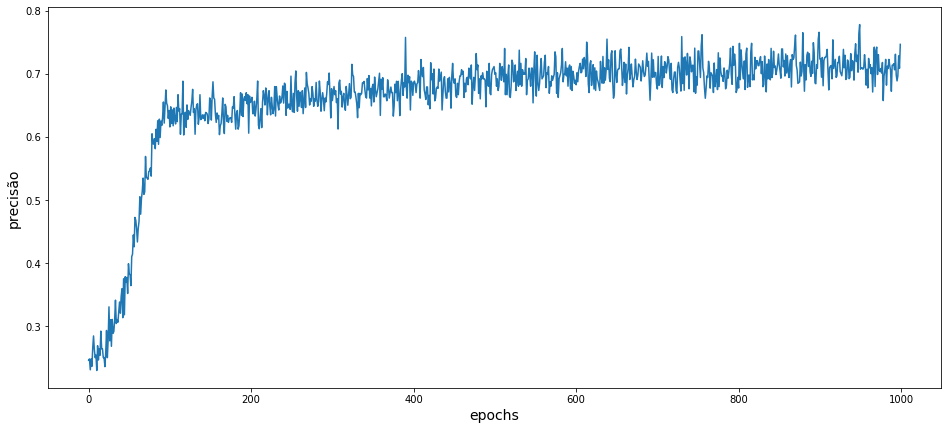

In [157]:
plt.figure(figsize=(16,7))
plt.xlabel("epochs", fontsize=14)
plt.ylabel("precisão", fontsize=14)
plt.plot(range(len(d_precision)), d_precision);

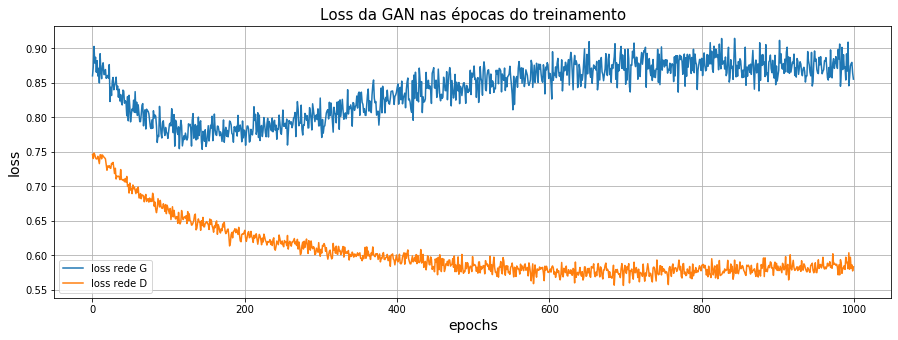

In [158]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(gloss)), gloss, label="loss rede G")
plt.plot(range(len(dloss)), dloss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

In [160]:
np.mean(obj_oc.D.predict_classes(X_train)==1)

0.6

In [161]:
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669
